# Riley, Alexander - Homework 2

We numerically explore the relationship between error distributions, objective functions (least squares versus least absolute deviation, and computational speed.

The following simulation creates a data set according to
$$y_i = \beta_1 + \beta_2 x_i + \beta_3 x_i^2 + \epsilon_i.$$

We generate $n$ observations from this model for $x$ on an equally spaced grid $[0,1]$. For $Yt$, the errors ($\epsilon_i$) have a t-distribution with 2 degrees of freedom. For $Yn$, the errors have a standard normal distribution. We plot each of these data sets and the true regression function.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1234)

In [2]:
n = 500
x = np.linspace(0,1,n)
X = np.array((np.ones(n),x,x**2)).T
beta = np.array([1,2,4])
Yt = np.matmul(X,beta) + np.random.standard_t(size=n, df=2)
Yn = np.matmul(X,beta) + np.random.normal(size=n)

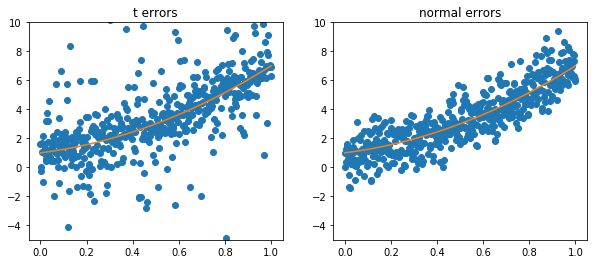

In [3]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title("t errors")
plt.plot(x,Yt,'o')
plt.plot(x,np.matmul(X,beta),'-')
plt.ylim(-5,10)
plt.subplot(122)
plt.title("normal errors")
plt.plot(x,Yn,'o')
plt.plot(x,np.matmul(X,beta),'-')
plt.ylim(-5,10)
plt.show()

The t distribution produces a lot of outliers (some outliers are not shown because we restricted the y-axis to ylim in each plot). Given the data, out goal is to infer the parameters $\beta$. We will consider two methods. The least squares method we discussed in class is
$$ \beta_{LS} = \text{argmin}_{\beta} (y_i - \beta_1 - \beta_2 x_i - \beta_3 x_i^2)^2 =  \text{argmin}_{\beta} (Y - X\beta)^T(Y - X\beta) = (X^TX)^{-1}X^TY$$
A second possibility is to find the [least absolute deviations](https://en.wikipedia.org/wiki/Least_absolute_deviations) estimator. We call this $\beta_{LAD}$ which has the form
$$\beta_{LAD} = \text{argmin}_{\beta} |y_i - \beta_1 - \beta_2 x_i - \beta_3 x_i^2|.$$
This may also be known as $L_1$ regression or quantile regression with the $0.5$ quantile.

In this homework you will fit both $\beta_{LS}$ and $\beta_{LAD}$ and compare the methods based on parameter estimation accuracy and speed.

## Question 1

Fixing $X$, generate the $Yt$ and $Yn$ data $N=100$ times (note that $n$ is the sample size and $N$ is the number of times we run the simulation). Compute $\beta_{LS}$ and $\beta_{LAD}$ each time. Since $\beta$ is a vector of length $3$, this will result in 4 matrices (LS for $Yt$ and $Yn$ and LAD for $Yt$ and $Yn$) with $N$ rows and 3 columns (you could store this output in other formats as well, but matrices are convenient).

In [4]:
from scipy.linalg import lstsq
from statsmodels.regression.quantile_regression import QuantReg

N = 100

LS_Yt, LS_Yn = np.zeros((N, 3)), np.zeros((N, 3))
LAD_Yt, LAD_Yn = np.zeros((N, 3)), np.zeros((N, 3))
for i in range(N):
    Yt = np.matmul(X,beta) + np.random.standard_t(size=n, df=2)
    Yn = np.matmul(X,beta) + np.random.normal(size=n)
    
    LS_Yn[i] = lstsq(X,Yn)[0]
    LS_Yt[i] = lstsq(X,Yt)[0]
    
    LAD_Yn[i] = QuantReg(Yn, X).fit(q=0.5, max_iter=10000).params
    LAD_Yt[i] = QuantReg(Yt, X).fit(q=0.5, max_iter=4000).params

Make scatterplots of $\beta_2$ versus $\beta_3$ estimates for each type of data, estimator. This will produce four scatterplots. Mark the true $\beta_2$ and $\beta_3$ on each plot and comment of the quality of the estimators in the different settings. You scatterplot should look similar to the ones below.

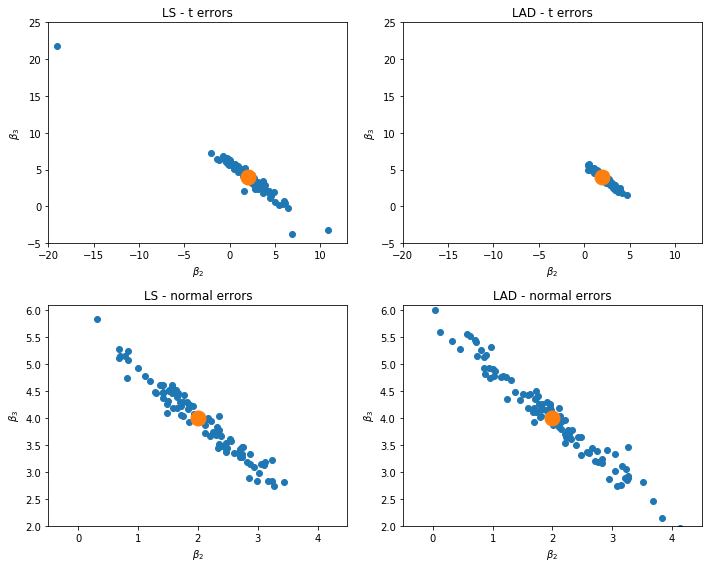

In [5]:
plt.figure(figsize=(10,8))
plt.subplot(221)
plt.plot(LS_Yt[:,1], LS_Yt[:,2], 'o')
plt.plot(beta[1], beta[2], 'o', markersize=15)
plt.xlim(-20,13)
plt.ylim(-5,25)
plt.title("LS - t errors")
plt.xlabel(r'$\beta_2$')
plt.ylabel(r'$\beta_3$')

plt.subplot(222)
plt.plot(LAD_Yt[:,1], LAD_Yt[:,2], 'o')
plt.plot(beta[1], beta[2], 'o', markersize=15)
plt.xlim(-20,13)
plt.ylim(-5,25)
plt.title("LAD - t errors")
plt.xlabel(r'$\beta_2$')
plt.ylabel(r'$\beta_3$')

plt.subplot(223)
plt.plot(LS_Yn[:,1], LS_Yn[:,2], 'o')
plt.plot(beta[1], beta[2], 'o', markersize=15)
plt.xlim(-0.5,4.5)
plt.ylim(2,6.1)
plt.title("LS - normal errors")
plt.xlabel(r'$\beta_2$')
plt.ylabel(r'$\beta_3$')

plt.subplot(224)
plt.plot(LAD_Yn[:,1], LAD_Yn[:,2], 'o')
plt.plot(beta[1], beta[2], 'o', markersize=15)
plt.xlim(-0.5,4.5)
plt.ylim(2,6.1)
plt.title("LAD - normal errors")
plt.xlabel(r'$\beta_2$')
plt.ylabel(r'$\beta_3$')

plt.tight_layout()
plt.show()

From these plots, it's clear that
* t-distributed errors: LAD is tighter around the correct value and has far less outliers than the LS case
* normal errors: the two are relatively close to each other, with LS being slightly tighter and less prone to outliers

## Question 2

Compare the speed of $\beta_{LS}$ to $\beta_{LAD}$ using a package such as benchmark in R or some of the tools [here](https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html) in python. Empirically determine the computational complexity (in $n$) of $\beta_{LAD}$ and $\beta_{LS}$ (we know from theoretical analysis that $\widehat{\beta}_{LS}$ should be linear in $n$).

First we compare the speeds of computing on the same data using %timeit. We'll do once for normal errors and once for t-distributed errors (note: this is using the most recent iteration of data from the previous loop).

In [6]:
%timeit lstsq(X,Yn)

241 µs ± 40.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [7]:
q = QuantReg(Yn, X)
%timeit q.fit(q=0.5, max_iter=10000)

18.4 ms ± 829 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
%timeit lstsq(X,Yt)

212 µs ± 30.2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [9]:
q = QuantReg(Yt, X)
%timeit q.fit(q=0.5, max_iter=4000)

26.2 ms ± 5.51 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


So from this we can see that regardless of the type of error, LS takes **much** less time to run than LAD optimization.  This is evident both in mean values and how many loops the algorithm decided to complete.

Now, to compute the Big-O runtime of both algorithms, I'm going to pick out a wide range of $n$ values, compute the fit multiple (5) times, then plot the median run time as a function of $n$.

In [10]:
import time
nvals = [int(n) for n in np.linspace(10**3,10**6,10)]

times_LS, times_LAD = [], []
for n in nvals:
    x = np.linspace(0,1,n)
    X = np.array((np.ones(n),x,x**2)).T
    Yt = np.matmul(X,beta) + np.random.standard_t(size=n, df=2)
    Yn = np.matmul(X,beta) + np.random.normal(size=n)
    
    q = QuantReg(Yn, X)
    
    timings_LS, timings_LAD = [], []
    for ii in range(5):
        start = time.time()
        betafit = q.fit(q=0.5).params
        end = time.time()
        timings_LAD.append(end-start)
        
        start = time.time()
        betafit = lstsq(X,Yn)[0]
        end = time.time()
        timings_LS.append(end-start)
    times_LS.append(np.median(timings_LS))
    times_LAD.append(np.median(timings_LAD))

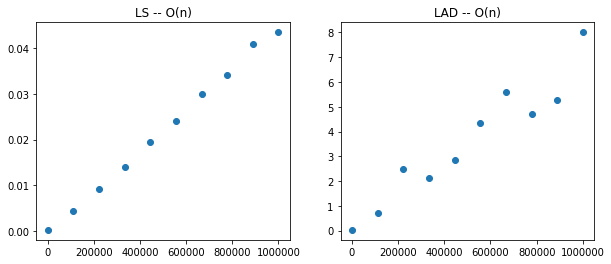

In [11]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(nvals, times_LS, 'o')
plt.title("LS -- O(n)")

plt.subplot(122)
plt.plot(nvals, times_LAD, 'o')
plt.title("LAD -- O(n)")
plt.show()

This is showing that both functions scale roughly linearly, so LAD is also $O(n)$ (we already knew LS was $O(n)$ from theory).